## Using Long Short Term Memory (LSTM) neural networks for cryptocurrency price movement prediction
* Forget gate: decides what information to throw away and what past information to remember
* Update/input gate: what new information is added and how much information is added
* Output gate: conditionally decided what to output from Memory 
<br> *Source: https://medium.com/@ahmetozlu93/long-short-term-memory-lstm-networks-in-a-nutshell-363cd470ccac*  
 
    


*Source code: https://www.youtube.com/watch?v=H6du_pfuznE&ab_channel=KrishNaik*

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read the file in from device
df = pd.read_csv('BTC_INR.csv')

In [3]:
# Change the index to the date
df = df.set_index(pd.DatetimeIndex(df['Date'].values)) 
df.index.name = 'Date'
df.drop(columns=['Date'], inplace=True)

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-24,531125.5625,534905.8750,528807.6250,532109.6250,532109.6250,1.155234e+12
2019-10-25,531911.8125,615708.6875,529882.0625,613524.0625,613524.0625,2.033467e+12
2019-10-26,614011.1875,709940.3750,613660.1875,654913.8125,654913.8125,3.152115e+12
2019-10-27,654682.5000,690656.6250,645532.4375,676643.4375,676643.4375,2.308897e+12
2019-10-28,677591.8125,693664.0625,654827.1250,654827.1250,654827.1250,2.189437e+12


In [6]:
# Check of null values in the data
filt = df['Open'].isnull()
df[filt]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-04,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# There is 1 day of missing values. Using linear interpolate to fill that value
df = df.interpolate()

In [10]:
# Missing values filled in using interpolate()
df[filt]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-04,834176.75,872190.40625,831134.90625,861993.21875,861993.21875,1.674818e+12


In [15]:
df1 = df['Close']

## Visualise the data

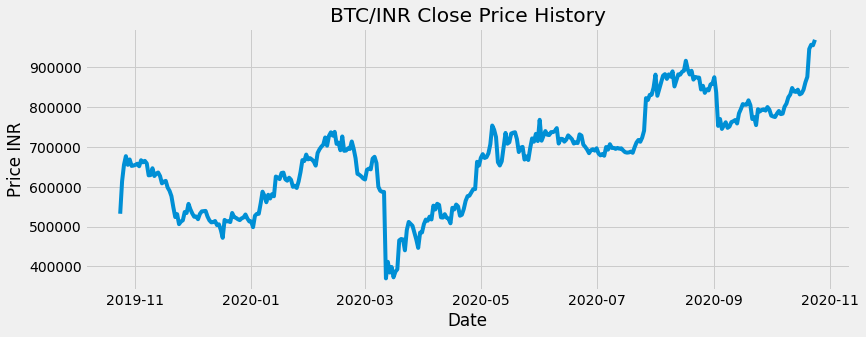

In [17]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(df1, label='Close')
plt.title('BTC/INR Close Price History')
plt.xlabel('Date')
plt.ylabel('Price INR')
plt.show()

In [21]:
# LSTMs are sensitive to scale of data
scaler = MinMaxScaler(feature_range=(0,1)) # The values we need to scale is between 0 and 1
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [29]:
# Splitting data into train-test split
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [48]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step -1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[1+time_step,0])
    return np.array(dataX), np.array(dataY)

In [57]:
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [58]:
X_train.shape

(227, 10)

In [60]:
# LSTMs need to reshaped into 3D (samples, time_step, features) -> add 1 to the existing shape 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [62]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
4/4 [==============================] - 2s 446ms/step - loss: 0.2043 - val_loss: 0.1145
Epoch 2/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0870 - val_loss: 0.0035
Epoch 3/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0151 - val_loss: 0.1427
Epoch 4/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0332 - val_loss: 0.0508
Epoch 5/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0092 - val_loss: 0.0034
Epoch 6/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0119 - val_loss: 0.0022
Epoch 7/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0117 - val_loss: 0.0025
Epoch 8/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0059 - val_loss: 0.0118
Epoch 9/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0053 - val_loss: 0.0190
Epoch 10/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0054 - val_loss: 0.0105
Epoch 11/100
4/4 [

In [65]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [68]:
# Transform back from MinMax Scaler
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [69]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

666322.633306939

In [124]:
math.sqrt(mean_squared_error(y_test, test_predict))

664815.1950847235

In [125]:
len(test_data)

129

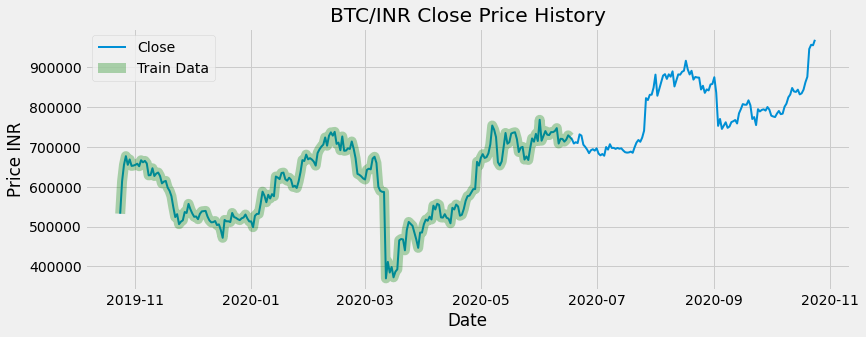

In [120]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(df.index, scaler.inverse_transform(df1), label='Close', alpha=1, linewidth=2) 
plt.plot(df.index[0:len(scaler.inverse_transform(train_data))], scaler.inverse_transform(train_data), label='Train Data', alpha=0.3, color='green', linewidth=10)
plt.title('BTC/INR Close Price History')
plt.xlabel('Date')
plt.ylabel('Price INR')
plt.legend(loc='upper left')
plt.show()

In [105]:
scaler.inverse_transform(train_data)[0:5]

array([[532109.625 ],
       [613524.0625],
       [654913.8125],
       [676643.4375],
       [654827.125 ]])

In [106]:
scaler.inverse_transform(df1)[0:5]

array([[532109.625 ],
       [613524.0625],
       [654913.8125],
       [676643.4375],
       [654827.125 ]])

In [94]:
ddd.shape

(238, 1)

In [95]:
fg = scaler.inverse_transform(train_data)

In [100]:
fg.shape

(238, 1)